In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import kde_from_sample, compute_prob_win, total_prob_win, compute_gain, expected_gain

In [3]:
def read_data(filename):
    df = pd.read_csv(Path.cwd() / 'data' / filename, index_col=0, skiprows=[1])
    return df.dropna().T

In [4]:
df2011 = read_data('showcases.2011.csv')
df2012 = read_data('showcases.2012.csv')
df = pd.concat([df2011, df2012], ignore_index=True)
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


<AxesSubplot:>

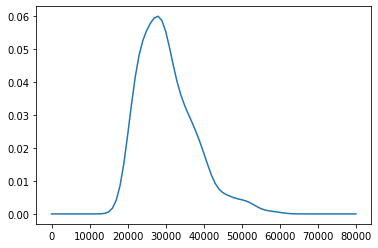

In [10]:
qs = np.linspace(0, 80000, 81)
ps = ss.gaussian_kde(df['Showcase 1'])(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.plot()

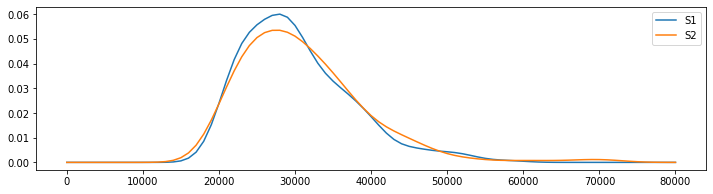

In [12]:
qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)
prior2 = kde_from_sample(df['Showcase 2'], qs)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
prior1.plot(ax=ax, label='S1')
prior2.plot(ax=ax, label='S2')
plt.legend()
plt.show()

In [13]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

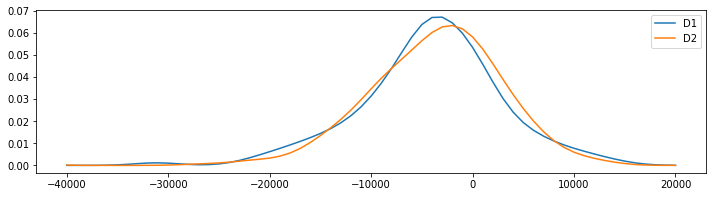

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
kde_diff1.plot(ax=ax, label='D1')
kde_diff2.plot(ax=ax, label='D2')
plt.legend()
plt.show()

In [16]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()
error_dist1 = ss.norm(0, std_diff1)
error_dist2 = ss.norm(0, std_diff2)

In [17]:
guess1 = 23000
error1 = guess1 - prior1.qs
# error_dist1에 error1을 집어넣고 likelihood를 파악하는 형태
likelihood1 = error_dist1.pdf(error1)
posterior1 = prior1 * likelihood1
posterior1.normalize()

3.3889812097254624e-05

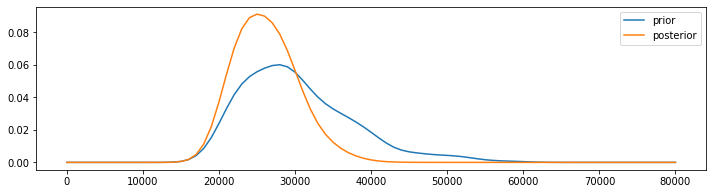

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
prior1.plot(ax=ax, label='prior')
posterior1.plot(ax=ax, label='posterior')
plt.legend()
plt.show()

In [19]:
guess2 = 38000
error2 = guess2 - prior2.qs
likelihood2 = error_dist2.pdf(error2)
posterior2 = prior2 * likelihood2
posterior2.normalize()

2.697812321910703e-05

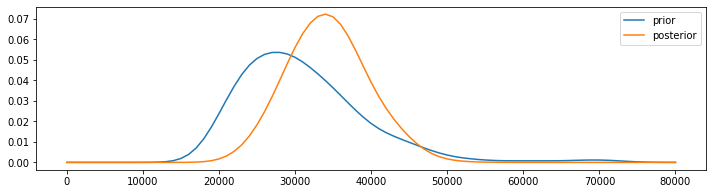

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
prior2.plot(ax=ax, label='prior')
posterior2.plot(ax=ax, label='posterior')
plt.legend()
plt.show()

In [21]:
# 생성함수 prob_overbid와 prob_worse_than의 합
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

<AxesSubplot:>

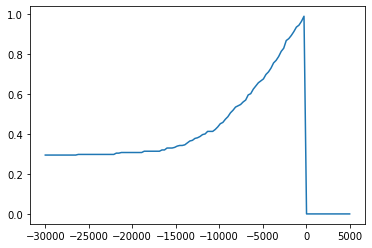

In [23]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs]
Pmf(ys, xs).plot()

In [24]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439813

In [32]:
bids = posterior1.qs
probs = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]
prob_win_series = Pmf(probs, bids)
prob_win_series.max_prob(), prob_win_series.max()

(21000.0, 0.6136807192359475)

<AxesSubplot:>

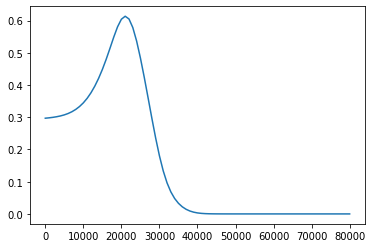

In [33]:
prob_win_series.plot()

In [34]:
bids = posterior1.qs
gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]
expected_gain_series = Pmf(gains, bids)
expected_gain_series.max_prob(), expected_gain_series.max()

(22000.0, 17384.8995844308)